# Demo

这是一个Neilyst回测系统V1.0版本的回测demo。

## Step 1：获取数据

In [12]:
from Neilyst import Neilyst

# 初始化币安U本位合约对象
# 如果想要对现货数据进行分析
# 将参数改为'binance'即可
# 如果需要别的交易所的数据
# 参考ccxt不同交易所的关键词即可
BTCUSDTyst = Neilyst('binanceusdm')

# 获取数据，参数含义分别为symbol，开始时间和结束时间，其中timeframe为一个可选参数，其值默认是1d，表示时间周期。
BTCUSDTyst.fetch('BTC/USDT', '2022-01-01T00:00:00Z', '2022-02-01T00:00:00Z', timeframe='1d')

# 获取的数据是一个dataframe，保存在ohlcv_data这个属性中
print(BTCUSDTyst.ohlcv_data.head())


                timestamp      open      high       low     close      volume
date                                                                         
2022-01-01  1640995200000  46210.57  47943.77  46210.55  47704.35  179433.584
2022-01-02  1641081600000  47704.35  48000.00  46605.68  47280.00  184795.093
2022-01-03  1641168000000  47280.01  47575.22  45665.40  46445.81  244781.793
2022-01-04  1641254400000  46445.80  47524.36  45445.57  45833.42  292149.750
2022-01-05  1641340800000  45833.41  47075.29  42270.00  43421.69  485477.569


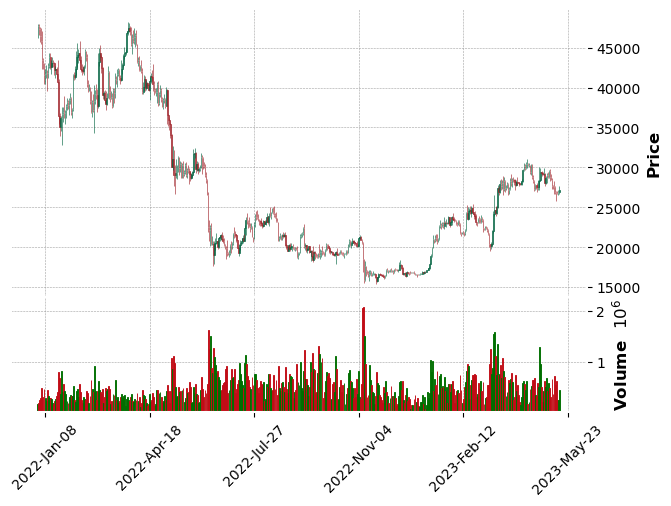

In [13]:
# 这个方法可以画出当前数据的蜡烛图

BTCUSDTyst.show_ohlcv()

## Step 2：指标构建

In [14]:
# 计算指标的方式
BTCUSDTyst.MA(20)
BTCUSDTyst.MA(60)

# 所有指标数据保存在indicators这个属性中
print(BTCUSDTyst.indicators.head())

                  MA20          MA60
date                                
2022-01-01  43289.1375  40960.614167
2022-01-02  43289.1375  40960.614167
2022-01-03  43289.1375  40960.614167
2022-01-04  43289.1375  40960.614167
2022-01-05  43289.1375  40960.614167


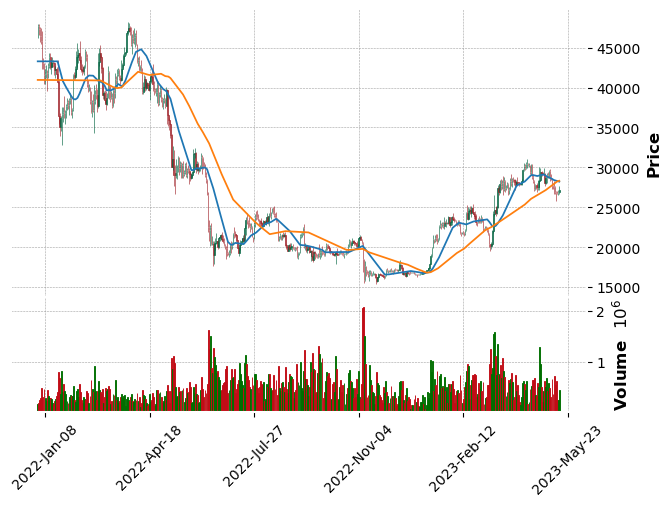

In [15]:
# 可以用如下的方式展示部分指标
BTCUSDTyst.show_indicators('MA20', 'MA60')

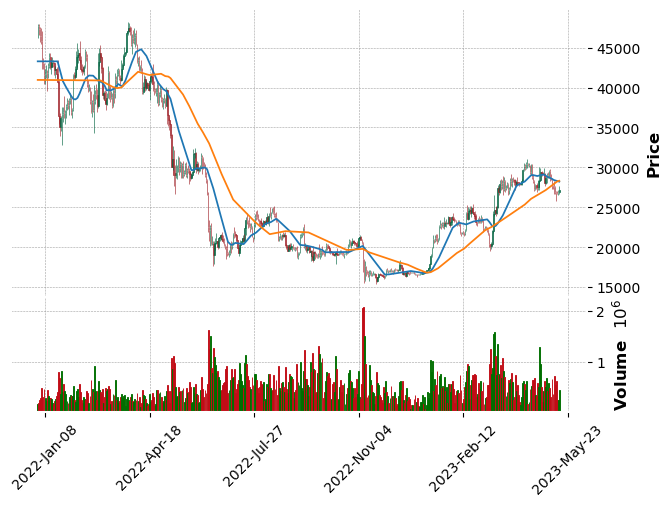

In [16]:
# 可以用如下的方式展示所有指标
BTCUSDTyst.show_all_indicators()

## Step 3：策略编写与回测

用户的策略应该写在一个class中，这个class必须有一个名为check_signal的方法，传入参数必须与我的一致。

其中:
* index的格式是timestamp：2022-01-01
* row是这样的一行：
  
| date       | timestamp     | open     | high     | low      | close    | volume     | MA20      | MA60              | pos | balance | total | entry_price |
|------------|---------------|----------|----------|----------|----------|------------|-----------|-------------------|-----|---------|-------|-------------|
| 2022-01-01 | 1640995200000 | 46210.57 | 47943.77 | 46210.55 | 47704.35 | 179433.584 | 43289.1375 | 40960.614166666666 | 0.0 | 10000.0 | 10000.0 | 0.0         |

* data参数包含了所有的row
* pos参数包含了当前的仓位

这个表中的参数前面的都展示过，后面的pos表示当前的仓位，balance表示当前可用的现金，total表示当前的总资产，entry_price表示开仓时买入的价格，是用来计算pnl的。

下文代码中展示了一个非常简单且**不挣钱**的双均线策略，用来展示这个回测引擎的用法。


In [17]:
class myStrategy:
    def __init__(self):
        self.short_window = 20
        self.long_window = 60

    def check_signal(self, index, row, data, pos, trade_record):
        # 获取当前行的位置
        current_index = data.index.get_loc(index)

        # 确保有足够的数据来计算MA
        if current_index < self.long_window:
            return None  # 不足够的数据来生成信号

        # 获取前一行的数据
        previous_row = data.iloc[current_index - 1]

        current_short_ma = row[f'MA{self.short_window}']
        current_long_ma = row[f'MA{self.long_window}']
        previous_short_ma = previous_row[f'MA{self.short_window}']
        previous_long_ma = previous_row[f'MA{self.long_window}']
        current_pos = pos

        # 开多信号
        if current_pos == 0 and previous_short_ma < previous_long_ma and current_short_ma > current_long_ma:
            return ['long']
        # 开空信号
        elif current_pos == 0 and previous_short_ma > previous_long_ma and current_short_ma < current_long_ma:
            return ['short']
        # 平多信号
        elif current_pos > 0 and previous_short_ma > previous_long_ma and current_short_ma < current_long_ma:
            return ['close', 'short']
        # 平空信号
        elif current_pos < 0 and previous_short_ma < previous_long_ma and current_short_ma > current_long_ma:
            return ['close', 'long']

        return None


In [18]:
# 设定好策略以后，使用如下的方式就可以调用回测引擎。

strategy = myStrategy()
BTCUSDTyst.run_backtest(strategy)

# 策略运行完成以后，所有的数据保存在data这个属性中。
BTCUSDTyst.data.head()

,timestamp,open,high,low,close,volume,MA20,MA60,pos,balance,total,entry_price
date,,,,,,,,,,,,
2022-01-01,1640995200000,46210.57,47943.77,46210.55,47704.35,179433.584,43289.1375,40960.614167,0.0,10000.0,10000.0,0.0
2022-01-02,1641081600000,47704.35,48000.00,46605.68,47280.00,184795.093,43289.1375,40960.614167,0.0,10000.0,10000.0,0.0
2022-01-03,1641168000000,47280.01,47575.22,45665.40,46445.81,244781.793,43289.1375,40960.614167,0.0,10000.0,10000.0,0.0
2022-01-04,1641254400000,46445.80,47524.36,45445.57,45833.42,292149.750,43289.1375,40960.614167,0.0,10000.0,10000.0,0.0
2022-01-05,1641340800000,45833.41,47075.29,42270.00,43421.69,485477.569,43289.1375,40960.614167,0.0,10000.0,10000.0,0.0


In [19]:
BTCUSDTyst.data.to_csv('data.csv')

In [20]:
# 交易记录保存在trade_record中
BTCUSDTyst.trade_record

,date,signal,price,amount,pnl
0,2022-03-16,long,41107.855290,0.243226,0
0,2022-03-23,close,42865.756605,0.243226,427.567339
0,2022-03-23,short,42865.756605,0.243153,0
0,2022-03-24,close,43975.598670,-0.243153,-269.861491
0,2022-03-24,long,43975.598670,0.230844,0
0,2022-04-23,close,39413.129245,0.230844,-1053.219933
0,2022-04-23,short,39413.129245,0.230775,0
0,2022-08-03,close,22802.640075,-0.230775,3833.286036
0,2022-08-03,long,22802.640075,0.566929,0
0,2022-08-31,close,20040.497925,0.566929,-1565.939666


In [21]:
# 关于这个策略的评价指标可以使用如下方法来展示
BTCUSDTyst.evaluate()

胜率: 0.27
盈亏比: 2.85
最大回撤: 0.40
收益率: 0.04


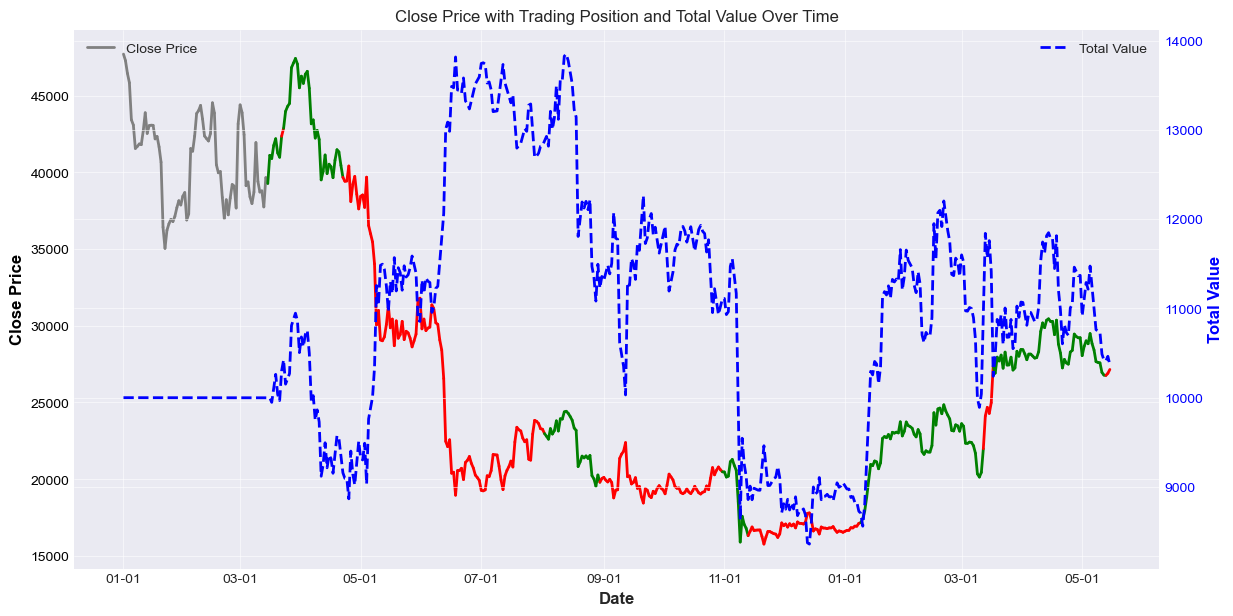

In [22]:
# 总资产变化曲线，symbol价格曲线，和开仓曲线画在了一张图上。
BTCUSDTyst.show_pnl()